# Libraries

In [143]:
import pandas as pd
import numpy  as np
import string 
import re
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
# import nltk
# from nltk.corpus import wordnet
# from nltk.stem import WordNetLemmatizer
# #from nltk.tokenize.treebank import TreebankWordDetokenizer
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
#from nltk.corpus import stopwords

from gensim.utils import simple_preprocess
from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import spacy
import pickle
import warnings
warnings.filterwarnings('ignore')


from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping

print('Done')



Done


# Data

In [104]:
pd.set_option('max_colwidth', None) 
df = pd.read_csv("~/Downloads/banData/MeTooHate.csv")[["text", "category"]]
#df.head()

## Undersample data

In [130]:
df1 = df[df["category"]== 1]
df1 = df[df["category"]== 1].dropna()
df0 = df[df["category"]== 0].dropna()
df = pd.concat([df0.sample(df1.shape[0]), df1], axis = 0)


#shuffle rows
df = df.sample(frac=1)
df.shape
df.reset_index(inplace = True)

df = df.head(100)

In [131]:
y = df["category"]
X = df.drop(columns = ["category"]) 

In [132]:
#df.head()

## Clean data

In [133]:
def clean_data(data):
    
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)
   
    # tokenize + remove scpecial characters + set to lower case
    data = text_to_word_sequence(data) 
    
    # Remove stopwords
    stop_words = set(stopwords.words('english')) 
    data = [w for w in data if not w in stop_words]         
    
    # Remove digits
    data = ' '.join(word for word in data if not word.isdigit())
    
    
    return text_to_word_sequence(data)

def apply_data_cleaning(X, text, drop_text = False):
    ln = X.shape[0]
    sentences = []
    for i in range(ln):
        tmp = X.iloc[i][f'{text}']
        tmp_clean = clean_data(tmp)
        sentences.append(tmp_clean)
    X["sentences"] = sentences
    if drop_text == True:
        X.drop(columns = f'{text}', inplace = True)
    return X


In [134]:
X = apply_data_cleaning(X = X, text = "text", drop_text = True) 

## Train-Test split


In [135]:
X = list(X.sentences)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
# print(len(X_train))
# print(len(y_train))
# print(len(X_test))
# print(len(y_test))

## Tokenize  data

In [136]:
# Initializes a Keras utilities that does all the tokenization for you
tokenizer = Tokenizer()

# The tokenization learns a dictionnary that maps a token (integer) to each word
# It can be done only on the train set - we are not supposed to know the test set !
# This tokenization also lower your words, apply some filters, and so on - you can check the doc if you want
tokenizer.fit_on_texts(X_train)
    
# We apply the tokenization to the train and test set
X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)
#X_test_token

In [137]:
## sjekk
# sentence_number = 10

# input_raw = X_train[sentence_number]
# input_token = X_train_token[sentence_number]
# for i in range(2):
#     print(f'Word : {input_raw[i]} -> Token {input_token[i]}')

### Add vocabulary

The dictionary that maps each word to a token can be accessed with `tokenizer.word_index`
    
Add a `vocab_size` variable that stores the number of different words (=tokens) in the train set. This is called the _size of the vocabulary_.

In [138]:
vocab_size = len(tokenizer.word_index)

print(f'There are {vocab_size} different words in the train set')

There are 753 different words in the train set


## Padding
_filling_ cells

In [139]:
X_train_pad = pad_sequences(X_train_token, dtype='float32', padding='post')
X_test_pad = pad_sequences(X_test_token, dtype='float32', padding='post')

!set maxlen <<< lower than longest sentence for efficiency/wt loss info

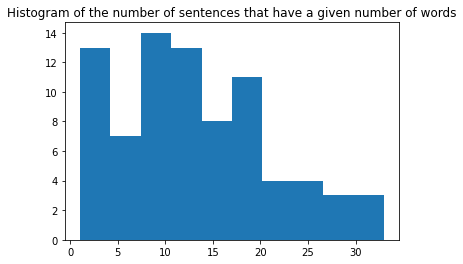

In [146]:
def plot_hist(X):
    len_ = [len(_) for _ in X]
    plt.hist(len_)
    plt.title('Histogram of the number of sentences that have a given number of words')
    plt.show()
    
plot_hist(X_train);

In [ ]:
X_train_pad = pad_sequences(X_train_token, dtype='float32', padding='post', maxlen=20)
X_test_pad = pad_sequences(X_test_token, dtype='float32', padding='post', maxlen=20)

# RNN

Let's now feed this data to a Recurrent Neural Network.

model:
- an embedding layer whose `input_dim` is the size of your vocabulary (= your `vocab_size`), and whose `output_dim` is the size of the embedding space you want to have
- a RNN (SimpleRNN, LSTM, GRU) layer
- a Dense layer
- an output layer

⚠️ **Warning** ⚠️ Here, you don't need a masking layer. Why? Because `layers.Embedding` has a argument to do that directly, which you have to set with `mask_zero=True`. That also means that your data **HAVE TO** be padded with **0** (which is the default behavior). See the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding#example_2) to understand how it **impacts** the `input_dim`.

!`input_dim` should equal size of vocabulary + 1


Compile it with the appropriate arguments

In [140]:
embedding_dimension = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size + 1, output_dim=embedding_dimension, mask_zero=True))
model.add(layers.LSTM(20))
model.add(layers.Dense(10, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [141]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 50)          37700     
                                                                 
 lstm_2 (LSTM)               (None, 20)                5680      
                                                                 
 dense_4 (Dense)             (None, 10)                210       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 43,601
Trainable params: 43,601
Non-trainable params: 0
_________________________________________________________________


In [142]:
#print(f'Expected number of parameters : {(vocab_size + 1) * embedding_dimension}')
es = EarlyStopping(patience=4, restore_best_weights=True)

model.fit(X_train_pad, y_train, 
          epochs=20, 
          batch_size=16,
          validation_split=0.3,
          callbacks=[es]
         )

Epoch 1/20
4/4 [==============================] - 3s 391ms/step - loss: 0.6924 - accuracy: 0.5179 - val_loss: 0.6976 - val_accuracy: 0.2917
Epoch 2/20
4/4 [==============================] - 0s 19ms/step - loss: 0.6853 - accuracy: 0.6071 - val_loss: 0.7034 - val_accuracy: 0.2917
Epoch 3/20
4/4 [==============================] - 0s 19ms/step - loss: 0.6761 - accuracy: 0.5893 - val_loss: 0.7066 - val_accuracy: 0.2917
Epoch 4/20
4/4 [==============================] - 0s 19ms/step - loss: 0.6619 - accuracy: 0.6786 - val_loss: 0.7119 - val_accuracy: 0.2917
Epoch 5/20
4/4 [==============================] - 0s 19ms/step - loss: 0.6406 - accuracy: 0.7857 - val_loss: 0.7206 - val_accuracy: 0.2917


## Improve efficiency
We will reduce the computational time. To do start, let's first look at how many words there are in the different sentences of your train set. 
Because of a very few number of sentences, one dimension of your tensor is equal to something like 1000. And most of the sentences that have 200 words have just padded values that are useless.

So your tensor is mostly useless information. But which still takes time to train.

But what if you pad the data to a maximum length (maxlen) of say 200 (words)?

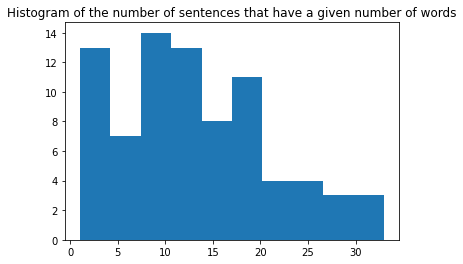

In [145]:
def plot_hist(X):
    len_ = [len(_) for _ in X]
    plt.hist(len_)
    plt.title('Histogram of the number of sentences that have a given number of words')
    plt.show()
    
plot_hist(X_train);


# Useful notes

# Keras documentation

- padding : https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
- embedding: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding#example_2